In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
from collections import defaultdict

from lobio.simulator_queue import Simulator
from lobio.accounting.pnl_counter import PnL_Counter
from lobio.model.avellaneda_stoikov_model import AvellanedaStoikov
from lobio.lob.limit_order import LimitOrder, PRICE_TICK, AMOUNT_TICK
from lobio.lob.order_book import TraderId, OrderBook, Side
from bisect import bisect_left
from copy import copy

%load_ext autoreload
%autoreload 2

In [2]:
diffs_file = "../data/diffs_prepared.json"
init_lob_file = "../data/init_lob_prepared.json"
trades_file = "../data/trades_prepared.csv"

with open(diffs_file, "r", encoding="utf-8") as file:
    diffs = json.load(file)
with open(init_lob_file, "r", encoding="utf-8") as file:
    init_lob = json.load(file)

trades = pd.read_csv(trades_file)

In [3]:
trades_by_diff = []

trades_index = 0
for v in diffs:
    time_to = v[0]
    trades_after_diff = []
    cur_trade = trades.iloc[trades_index]
    while (cur_trade["timestamp"] <= time_to) and (trades_index + 1 < len(trades)):
        limit_order = LimitOrder(
            float(cur_trade["price"]),
            float(cur_trade["amount"]),
            int(cur_trade["side"]),
            TraderId.MARKET,
        )
        trades_after_diff.append((cur_trade["timestamp"], limit_order))
        trades_index += 1
        cur_trade = trades.iloc[trades_index]
    trades_by_diff.append(trades_after_diff)

In [85]:
features = pd.read_csv('features.csv', index_col=0)
order_book = OrderBook.create_lob_init(init_lob)

In [88]:
pd.to_datetime(features.index, unit='ms')

DatetimeIndex(['2023-11-17 19:59:05.100000', '2023-11-17 19:59:05.201000',
               '2023-11-17 19:59:05.301000', '2023-11-17 19:59:05.401000',
               '2023-11-17 19:59:05.501000', '2023-11-17 19:59:05.601000',
               '2023-11-17 19:59:05.701000', '2023-11-17 19:59:05.801000',
               '2023-11-17 19:59:05.901000', '2023-11-17 19:59:06.001000',
               ...
               '2023-11-17 20:15:44.094000', '2023-11-17 20:15:44.194000',
               '2023-11-17 20:15:44.294000', '2023-11-17 20:15:44.394000',
               '2023-11-17 20:15:44.494000', '2023-11-17 20:15:44.594000',
               '2023-11-17 20:15:44.694000', '2023-11-17 20:15:44.794000',
               '2023-11-17 20:15:44.894000', '2023-11-17 20:15:44.994000'],
              dtype='datetime64[ns]', name='timestamp', length=9904, freq=None)

In [5]:
mid_prices = []
for i, diff in enumerate(tqdm(diffs)):
    mid_prices.append(order_book.mid_price())
    cur_trades = trades_by_diff[i]
    for _, limit_order in cur_trades:
        order_book.set_limit_order(copy(limit_order), set())
    order_book.apply_historical_update(diff, set())

mid_prices = np.array(mid_prices)

  0%|          | 0/9904 [00:00<?, ?it/s]

100%|██████████| 9904/9904 [00:01<00:00, 4973.91it/s]


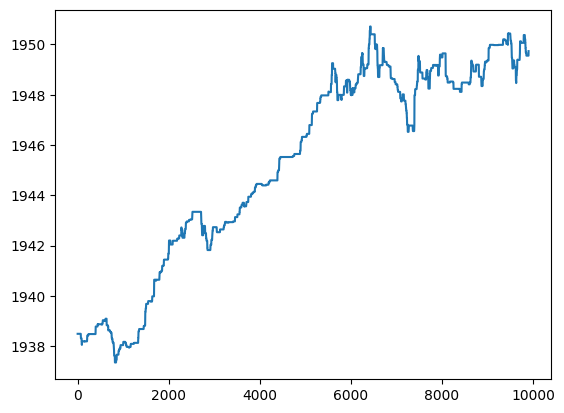

In [6]:
plt.plot(mid_prices)
plt.show()

In [7]:
lag_size = 100
moves = mid_prices[lag_size:] - mid_prices[:-lag_size]
moves

array([-0.3 , -0.3 , -0.3 , ..., -0.82, -0.82, -0.64])

In [8]:
part_indices = [1, 2, 5, 8, 9]

features.head()

,midprice_w,spread,mid_price,imbalance_ask,imbalance_bid,trade_imbalance_1000ms,past_returns_5000ms,log_return,auto_corr1lag,realized_volatility,real_kernel_H3
timestamp,,,,,,,,,,,
1700251145100,1938.499671,0.01,1938.495,1.778173,-1.110223e-11,0,0.0,0.0,0.0,0.0,0.0
1700251145201,1938.493591,0.01,1938.495,0.000000,-1.110223e-11,0,0.0,0.0,0.0,0.0,0.0
1700251145301,1938.492478,0.01,1938.495,0.000000,-1.110223e-11,2,0.0,0.0,0.0,0.0,0.0
1700251145401,1938.492249,0.01,1938.495,0.000000,-1.110223e-11,2,0.0,0.0,0.0,0.0,0.0
1700251145501,1938.491860,0.01,1938.495,0.000000,-1.110223e-11,2,0.0,0.0,0.0,0.0,0.0


In [9]:
t0 = diffs[0][0]
T = diffs[-1][0] + 100

pnl_counter = PnL_Counter()
features = features.values
small_features = features[:, part_indices]

In [27]:
order_book = OrderBook.create_lob_init(init_lob)
pnl_counter = PnL_Counter()
market_latency, local_latency = 10, 30

last_trade_price = order_book.ask_price()
pnl_history = [0.0]
q = 0.0
wealth = 0.0

my_orders_data = defaultdict(list)
my_prices = set()

for i, diff in enumerate(tqdm(diffs)):
    #print('1', my_prices)
    #print(i)
    if diff[0] > T:
        break
    
    # train model

    cur_trades = trades_by_diff[i]
    cur_features = features[i]

    my_bids, my_asks = [], []
    if (not i % 100) and (i < len(moves)):
        quote = 1
        if moves[i] > 0:
            price = order_book.bid_price()
            if price not in my_orders_data:
                my_bids = [LimitOrder(price, quote, Side.BUY, TraderId.MM)]
            #print('MADE ORDER', my_bids[0])
        elif moves[i] < 0:
            price = order_book.ask_price()
            if price not in my_orders_data:
                my_asks = [LimitOrder(price, quote, Side.SELL, TraderId.MM)]

            #print('MADE ORDER', my_asks[0])
    #print('2', my_prices)
    market_interaction = diff[0] + market_latency + local_latency
    my_order_index = bisect_left(
        cur_trades, market_interaction, key=lambda x: x[0]
    )
    trades_before = copy(cur_trades[:my_order_index])
    trades_after = copy(cur_trades[my_order_index:])
    #print('3', my_prices)
    #print(cur_trades)
    #print('1', order_book.asks[0], order_book.bids[0])
    for _, limit_order in trades_before:
        match_info = order_book.set_limit_order(limit_order, my_prices)
        #print('after 1 trades', order_book.asks[0], order_book.bids[0])
        sign = 2 * limit_order.side - 1
        my_match_info = match_info[TraderId.MM]
        if len(my_match_info):
            q += sign * my_match_info[0]
            wealth += -sign * my_match_info[1]
            pnl_counter.change_pnl(
                last_trade_price, order_book.ask_price(), q
            )
            last_trade_price = order_book.ask_price()
    #print('4', my_prices)
    #print('2', order_book.asks[0], order_book.bids[0])
    for my_order in my_bids + my_asks:
        #print('MY', my_order)
        match_info = order_book.set_limit_order(my_order, my_prices)
        sign = 2 * my_order.side - 1
        for _, v in match_info.items():
            q += -sign * v[0]
            wealth += sign * v[1]
        pnl_counter.change_pnl(last_trade_price, order_book.ask_price(), q)
        last_trade_price = order_book.ask_price()
    #print('5', my_prices)
    #print('3', order_book.asks[0], order_book.bids[0])
    for _, limit_order in trades_after:
        match_info = order_book.set_limit_order(limit_order, my_prices)
        sign = 2 * limit_order.side - 1
        my_match_info = match_info[TraderId.MM]
        if len(my_match_info):
            q += sign * my_match_info[0]
            wealth += -sign * my_match_info[1]
            pnl_counter.change_pnl(
                last_trade_price, order_book.ask_price(), q
            )
            last_trade_price = order_book.ask_price()
    #print('4', order_book.asks[0], order_book.bids[0])
    #print('6', my_prices)
    q = round(q, AMOUNT_TICK)
    wealth = round(wealth, PRICE_TICK)
    pnl_history.append(pnl_counter.pnl)
    order_book.apply_historical_update(diff, my_prices)
    #print('5', order_book.asks[0], order_book.bids[0])
    #print('7', my_prices)
    my_orders_data = defaultdict(list)
    #print('8', my_prices)
    
    for my_order_price in my_prices:
        # drift
        #print(i)
        my_orders_data[my_order_price[0]] = order_book.get_my_order_data(my_order_price)
    
    # if i > 1000:
    #     break
pnl_counter.change_pnl(last_trade_price, order_book.ask_price(), q)
pnl_history.append(pnl_counter.pnl)

  0%|          | 0/9904 [00:00<?, ?it/s]

100%|██████████| 9904/9904 [00:03<00:00, 2976.99it/s]


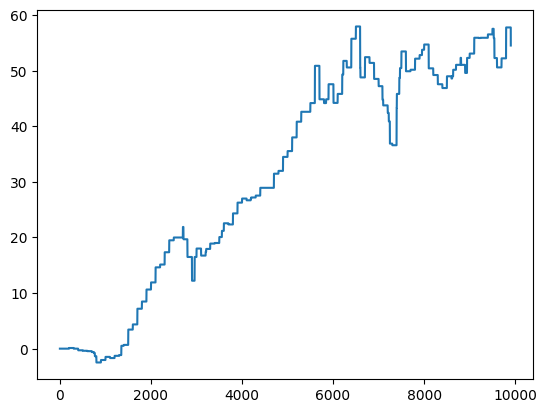

In [52]:
pnl_opt = pnl_history
plt.plot(pnl_opt)

In [53]:
q, order_book.ask_price(), wealth

(5.2447, 1949.76, -10168.69)

In [54]:
q * order_book.ask_price() + wealth

57.21627199999966

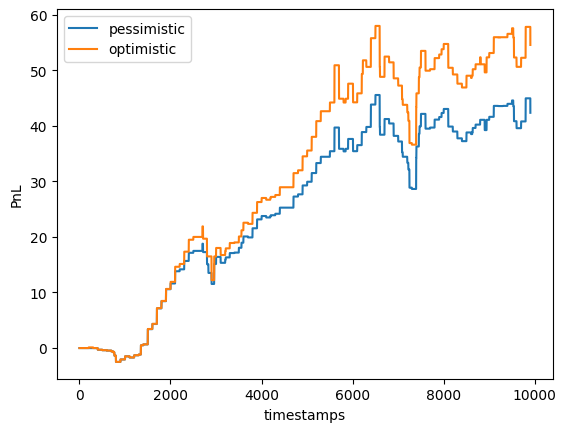

In [56]:
pnl_neg = pnl_history
plt.plot(pnl_neg, label='pessimistic')
plt.plot(pnl_opt, label='optimistic')
# plt.plot(pnl_rl, label='RL')
plt.legend()
plt.xlabel('timestamps')
plt.ylabel('PnL')
plt.show()

In [28]:
q, order_book.ask_price(), wealth

(5.3899, 1949.76, -10462.61)

In [29]:
q * order_book.ask_price() + wealth

46.40142399999968

In [10]:
from typing import Tuple#, Dict, Type, Any, Optional, Callable
#from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torch.distributions.multivariate_normal import MultivariateNormal
from sklearn.metrics import mean_squared_error
from numba import njit

In [11]:
class GaussianPDFModel(nn.Module):
    """Model for REINFORCE algorithm that acts like f(x) + normally distributed noise"""

    def __init__(
        self,
        dim_observation: int,
        dim_action: int,
        dim_hidden: int,
        std: float,
        action_bounds: np.array,
        scale_factor: float,
        leakyrelu_coef=0.2,
    ):
        """Initialize model.

        Args:
            dim_observation (int): dimensionality of observation
            dim_action (int): dimensionality of action
            dim_hidden (int): dimensionality of hidden layer of perceptron (dim_hidden = 4 works for our case)
            std (float): standard deviation of noise (\\sigma)
            action_bounds (np.array): action bounds with shape (dim_action, 2). `action_bounds[:, 0]` - minimal actions, `action_bounds[:, 1]` - maximal actions
            scale_factor (float): scale factor for last activation (L coefficient) (see details above)
            leakyrelu_coef (float): coefficient for leakyrelu
        """

        super().__init__()

        self.dim_observation = dim_observation
        self.dim_action = dim_action
        self.dim_hidden = dim_hidden
        self.leakyrelu_coef = leakyrelu_coef
        self.std = std

        self.scale_factor = scale_factor
        self.register_parameter(
            name="scale_tril_matrix",
            param=torch.nn.Parameter(
                (self.std * torch.eye(self.dim_action)).float(),
                requires_grad=False,
            ),
        )
        self.register_parameter(
            name="action_bounds",
            param=torch.nn.Parameter(
                torch.tensor(action_bounds).float(),
                requires_grad=False,
            ),
        )

        self.perceptron = nn.Sequential(nn.Linear(self.dim_observation, self.dim_hidden), nn.LeakyReLU(self.leakyrelu_coef), 
                                        nn.Linear(self.dim_hidden, self.dim_hidden), nn.LeakyReLU(self.leakyrelu_coef), 
                                        nn.Linear(self.dim_hidden, self.dim_action))
    
    def get_unscale_coefs_from_minus_one_one_to_action_bounds(
        self,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        """Calculate coefficients for linear transformation from [-1, 1] to [U_min, U_max].

        Returns:
            Tuple[torch.FloatTensor, torch.FloatTensor]: coefficients
        """

        action_bounds = self.get_parameter("action_bounds")
        beta_ = action_bounds.mean(dim=1)
        lambda_ = action_bounds[:, 1] - beta_

        return beta_, lambda_
    
    def unscale_from_minus_one_one_to_action_bounds(
        self, x: torch.FloatTensor
    ) -> torch.FloatTensor:
        """Linear transformation from [-1, 1] to [U_min, U_max].

        Args:
            x (torch.FloatTensor): tensor to transform

        Returns:
            torch.FloatTensor: transformed tensor
        """

        (
            unscale_bias,
            unscale_multiplier,
        ) = self.get_unscale_coefs_from_minus_one_one_to_action_bounds()

        return x * unscale_multiplier + unscale_bias

    def scale_from_action_bounds_to_minus_one_one(
        self, y: torch.FloatTensor
    ) -> torch.FloatTensor:
        """Linear transformation from [U_min, U_max] to [-1, 1].

        Args:
            y (torch.FloatTensor): tensor to transform

        Returns:
            torch.FloatTensor: transformed tensor
        """

        (
            unscale_bias,
            unscale_multiplier,
        ) = self.get_unscale_coefs_from_minus_one_one_to_action_bounds()

        return (y - unscale_bias) / unscale_multiplier
    
    def get_means(self, observations: torch.FloatTensor) -> torch.FloatTensor:
        """Return mean for MultivariateNormal from `observations`

        Args:
            observations (torch.FloatTensor): observations

        Returns:
            torch.FloatTensor: means
        """

        out = self.perceptron(observations)
        return (1 - 3 * self.std) * torch.tanh(out / self.scale_factor)
    
    def split_to_observations_actions(
        self, observations_actions: torch.FloatTensor
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        """Split input tensor to tuple of observation(s) and action(s)

        Args:
            observations_actions (torch.FloatTensor): tensor of catted observations actions to split

        Raises:
            ValueError: in case if `observations_actions` has dimensinality greater than 2

        Returns:
            Tuple[torch.FloatTensor, torch.FloatTensor]: tuple of observation(s) and action(s)
        """

        if len(observations_actions.shape) == 1:
            observation, action = (
                observations_actions[: self.dim_observation],
                observations_actions[self.dim_observation :],
            )
        elif len(observations_actions.shape) == 2:
            observation, action = (
                observations_actions[:, : self.dim_observation],
                observations_actions[:, self.dim_observation :],
            )
        else:
            raise ValueError("Input tensor has unexpected dims")

        return observation, action
    
    def log_probs(self, observations: torch.FloatTensor, actions: torch.FloatTensor) -> torch.FloatTensor:
        """Get log pdf from the batch of observations actions

        Args:
            batch_of_observations_actions (torch.FloatTensor): batch of catted observations and actions

        Returns:
            torch.FloatTensor: log pdf(action | observation) for the batch of observations and actions
        """

        scale_tril_matrix = self.get_parameter("scale_tril_matrix")

        scaled_mean = self.get_means(observations)
        #print(scaled_mean)
        scaled_action = self.scale_from_action_bounds_to_minus_one_one(actions)
        #print(scaled_action)
        log_probs = MultivariateNormal(scaled_mean, scale_tril=scale_tril_matrix).log_prob(scaled_action.reshape(-1, self.dim_action))
        return log_probs
    
    def sample(self, observation: torch.FloatTensor) -> torch.FloatTensor:
        """Sample action from `MultivariteNormal(lambda * self.get_means(observation) + beta, lambda ** 2 * Diag[self.std] ** 2)`

        Args:
            observation (torch.FloatTensor): current observation

        Returns:
            torch.FloatTensor: sampled action
        """
        action_bounds = self.get_parameter("action_bounds")
        scale_tril_matrix = self.get_parameter("scale_tril_matrix")

        scaled_mean = self.get_means(observation)
        sampled_scaled_action = MultivariateNormal(scaled_mean, scale_tril=scale_tril_matrix).sample()
        sampled_action = self.unscale_from_minus_one_one_to_action_bounds(sampled_scaled_action)

        return torch.clamp(
            sampled_action, action_bounds[:, 0], action_bounds[:, 1]
        )

In [66]:
np.random.seed(0)
torch.manual_seed(0)

dim_observation = 15
dim_action = 1
dim_hidden = 64
std = 0.001
is_base = True

model = GaussianPDFModel(
    dim_observation=dim_observation,
    dim_action=dim_action,
    action_bounds=np.array([[0, 1]]),
    scale_factor=5,
    dim_hidden=dim_hidden,
    std=std, # SMALL!
)

# perceptron = nn.Sequential(nn.Linear(15, 64), nn.LeakyReLU(0.2), 
#                                 nn.Linear(64, 64), nn.LeakyReLU(0.2), 
#                                 nn.Linear(64, 1), nn.Sigmoid())

lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [67]:
@njit
def shift_numba(x):
    for i in range(1, len(x)):
        x[i] = np.append(x[i, i:], np.zeros_like(x[i, :i]))
    return x  

In [68]:
### CHECK IF WE SET ONLY 1 ORDER PER PRICE LEVEL
np.random.seed(0)
torch.manual_seed(0)

market_latency, local_latency = 10, 30
N_iterations = 10
gamma = 0.999
betas = [0.0 for _ in diffs]
cost_per_iter = []
gammas = np.array([gamma**j for j in range(len(diffs))])
# pbar1 = tqdm(total=N_iterations, position=0)
# pbar2 = tqdm(total=len(diffs), position=1)

for _ in tqdm_notebook(range(N_iterations)):
    order_book = OrderBook.create_lob_init(init_lob)
    pnl_counter = PnL_Counter()

    my_orders_data = defaultdict(list)
    my_prices = set()
    # last_trade_price = order_book.ask_price()
    # pnl_history = [0.0]
    # q = 0.0
    # wealth = 0.0

    train_data_per_ts = []
    running_cost = 0.0
    all_observations = []
    all_actions = []
    all_rewards = []
    divisors = []
    for i, diff in enumerate(diffs):
        if diff[0] > T:
            break
        
        cur_features = features[i]

        current_observations = []
        current_targets = []
        for price, orders in my_orders_data.items():
            for order in orders:
                observation = np.append([price, *order[1:]], cur_features)
                target = order[0]
                current_observations.append(observation)
                current_targets.append(target)

        if len(current_observations):
            current_observations = np.array(current_observations)
            actions = model.sample(torch.tensor(current_observations).float()).detach().cpu().numpy().reshape(-1, )
            #print(actions)
            rewards = mean_squared_error(current_targets, actions)

            all_observations.append(current_observations)
            all_actions.append(actions)
            train_data_per_ts.append([current_observations,
                                    actions,
                                    rewards])
            running_cost += gamma**i * np.mean(rewards)
            all_rewards.append(np.mean(rewards))
            divisors.append(1)
        else:
            train_data_per_ts.append([])
            all_rewards.append(0)
            divisors.append(1e-10)
        # train model

        cur_trades = copy(trades_by_diff[i])

        my_bids, my_asks = [], []
        if (not i % 100) and (i < len(moves)):
            quote = 1
            if moves[i] > 0:
                price = order_book.bid_price()
                if price not in my_orders_data:
                    my_bids = [LimitOrder(price, quote, Side.BUY, TraderId.MM)]
            elif moves[i] < 0:
                price = order_book.ask_price()
                if price not in my_orders_data:
                    my_asks = [LimitOrder(price, quote, Side.SELL, TraderId.MM)]

        market_interaction = diff[0] + market_latency + local_latency
        my_order_index = bisect_left(
            cur_trades, market_interaction, key=lambda x: x[0]
        )
        trades_before = cur_trades[:my_order_index]
        trades_after = cur_trades[my_order_index:]

        for _, limit_order in trades_before:
            match_info = order_book.set_limit_order(limit_order, my_prices)

            # sign = 2 * limit_order.side - 1
            # my_match_info = match_info[TraderId.MM]
            # if len(my_match_info):
            #     q += sign * my_match_info[0]
            #     wealth += -sign * my_match_info[1]
            #     pnl_counter.change_pnl(
            #         last_trade_price, order_book.ask_price(), q
            #     )
            #     last_trade_price = order_book.ask_price()

        for my_order in my_bids + my_asks:
            match_info = order_book.set_limit_order(my_order, my_prices)
            # sign = 2 * my_order.side - 1
            # for _, v in match_info.items():
            #     q += -sign * v[0]
            #     wealth += sign * v[1]
            # pnl_counter.change_pnl(last_trade_price, order_book.ask_price(), q)
            # last_trade_price = order_book.ask_price()

        for _, limit_order in trades_after:
            match_info = order_book.set_limit_order(limit_order, my_prices)
            # sign = 2 * limit_order.side - 1
            # my_match_info = match_info[TraderId.MM]
            # if len(my_match_info):
            #     q += sign * my_match_info[0]
            #     wealth += -sign * my_match_info[1]
            #     pnl_counter.change_pnl(
            #         last_trade_price, order_book.ask_price(), q
            #     )
            #     last_trade_price = order_book.ask_price()
        
        # q = round(q, AMOUNT_TICK)
        # wealth = round(wealth, PRICE_TICK)
        # pnl_history.append(pnl_counter.pnl)
        order_book.apply_historical_update(diff, my_prices)

        my_orders_data = defaultdict(list)
        
        for my_order_price in my_prices:
            # drift
            my_orders_data[my_order_price[0]] = order_book.get_my_order_data(my_order_price)
        #pbar2.update(1)

    # pnl_counter.change_pnl(last_trade_price, order_book.ask_price(), q)
    # pnl_history.append(pnl_counter.pnl)
    divisors = np.cumsum(divisors)
    print(running_cost / divisors[-1])
    cost_per_iter.append(running_cost / divisors[-1])

    objective = 0.0 # vectorize log_probs !!!

    all_observations = np.concatenate(all_observations)
    all_actions = np.concatenate(all_actions)

    all_log_probs = model.log_probs(torch.tensor(all_observations).float(), 
                                    torch.tensor(all_actions).float())
# CUMSUM
    all_rewards = np.array(all_rewards)
    reward_matrix = np.repeat(all_rewards.reshape(1, -1), len(diffs), axis=0)
    reward_matrix = shift_numba(reward_matrix)
    weights = reward_matrix @ gammas
    pointer = 0
    for i, current_data in enumerate(train_data_per_ts):
        if len(current_data):
            # weight = 0.0
            # for j, future_data in enumerate(train_data_per_ts[i:]):
            #     if len(future_data):
            #         rewards = future_data[2]
            #         weight += gammas[j] * np.mean(rewards)
            if is_base:
                weight_shifted = weights[i] - betas[i]
                betas[i] = weights[i] #- IF BETAS NON ZERO THEN WE GET ALMOST ZERO COST MAYBE?!?
            else:
                weight_shifted = weights[i]
            # current_log_probs = model.log_probs(torch.tensor(current_data[0]).float(), 
            #                                     torch.tensor(current_data[1]).float())
            current_log_probs = all_log_probs[pointer:pointer+len(current_data)]
            objective += weight_shifted * torch.mean(current_log_probs) / divisors[i]
            pointer += len(current_data)
    optimizer.zero_grad()
    objective.backward()
    optimizer.step()

    #pbar1.update(1)

  0%|          | 0/10 [00:00<?, ?it/s]

0.08237247594671587
0.08237027823660378
0.0823697571886628
0.08237562600116526
0.08237380838987562
0.08237020961986283
0.08237223653175087
0.08237467611296906
0.08236968599730557
0.08237302778753128


In [69]:
with open(f'costs/{dim_hidden}_{features.shape[1]}_{is_base}.npy', 'wb') as f:
    np.save(f, np.array(cost_per_iter))

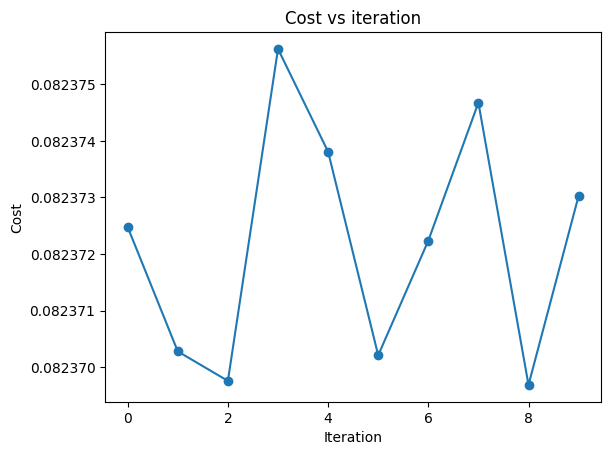

In [70]:
plt.plot(cost_per_iter, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs iteration')
plt.show()

In [71]:
torch.save(model.state_dict(), f'models/model_{dim_hidden}_{features.shape[1]}_{is_base}.pt')

In [72]:
# tmp_model = GaussianPDFModel(
#     dim_observation=dim_observation,
#     dim_action=dim_action,
#     action_bounds=np.array([[0, 1]]),
#     scale_factor=10,
#     dim_hidden=dim_hidden,
#     std=std,
# )

# tmp_model.load_state_dict(torch.load('models/model_rf.pt'))
# tmp_model.eval()

In [73]:
np.random.seed(0)
torch.manual_seed(0)


order_book = OrderBook.create_lob_init(init_lob)
pnl_counter = PnL_Counter()
market_latency, local_latency = 10, 30

last_trade_price = order_book.ask_price()
pnl_history = [0.0]
q = 0.0
wealth = 0.0

my_orders_data = defaultdict(list)
my_prices = set()

for i, diff in enumerate(tqdm(diffs)):
    if diff[0] > T:
        break
    
    # train model

    cur_trades = copy(trades_by_diff[i])
    cur_features = features[i]

    my_bids, my_asks = [], []
    if (not i % 100) and (i < len(moves)):
        quote = 1
        if moves[i] > 0:
            price = order_book.bid_price()
            if price not in my_orders_data:
                my_bids = [LimitOrder(price, quote, Side.BUY, TraderId.MM)]

        elif moves[i] < 0:
            price = order_book.ask_price()
            if price not in my_orders_data:
                my_asks = [LimitOrder(price, quote, Side.SELL, TraderId.MM)]

    market_interaction = diff[0] + market_latency + local_latency
    my_order_index = bisect_left(
        cur_trades, market_interaction, key=lambda x: x[0]
    )
    trades_before = cur_trades[:my_order_index]
    trades_after = cur_trades[my_order_index:]

    for _, limit_order in trades_before:
        match_info = order_book.set_limit_order(limit_order, my_prices)

        sign = 2 * limit_order.side - 1
        my_match_info = match_info[TraderId.MM]
        if len(my_match_info):
            q += sign * my_match_info[0]
            wealth += -sign * my_match_info[1]
            pnl_counter.change_pnl(
                last_trade_price, order_book.ask_price(), q
            )
            last_trade_price = order_book.ask_price()

    for my_order in my_bids + my_asks:

        match_info = order_book.set_limit_order(my_order, my_prices)
        sign = 2 * my_order.side - 1
        for _, v in match_info.items():
            q += -sign * v[0]
            wealth += sign * v[1]
        pnl_counter.change_pnl(last_trade_price, order_book.ask_price(), q)
        last_trade_price = order_book.ask_price()

    for _, limit_order in trades_after:
        match_info = order_book.set_limit_order(limit_order, my_prices)
        sign = 2 * limit_order.side - 1
        my_match_info = match_info[TraderId.MM]
        if len(my_match_info):
            q += sign * my_match_info[0]
            wealth += -sign * my_match_info[1]
            pnl_counter.change_pnl(
                last_trade_price, order_book.ask_price(), q
            )
            last_trade_price = order_book.ask_price()

    q = round(q, AMOUNT_TICK)
    wealth = round(wealth, PRICE_TICK)
    pnl_history.append(pnl_counter.pnl)
    order_book.apply_historical_update(diff, my_prices)

    
    my_orders_data = defaultdict(list)
    for my_order_price in my_prices:
        my_orders_data[my_order_price[0]] = order_book.get_my_order_data(my_order_price)
    
    current_observations = []
    for price, orders in my_orders_data.items():
        for order in orders:
            observation = np.append([price, *order[1:]], cur_features)
            current_observations.append(observation)

    if len(current_observations):
        current_observations = np.array(current_observations)
        actions = model.sample(torch.tensor(current_observations).float()).detach().cpu().numpy().reshape(-1, )

        ind = 0
        for price, orders in my_orders_data.items():
            if round(order_book.mid_price() - price, AMOUNT_TICK) > 0.5:
                continue
            for t, order in enumerate(orders):
                if t == 0:
                    ratio = actions[ind]
                    side = order[3]
                    amount = order[1]
                    new_margin = ratio * order[2]
                    order_book.shift_quote(price, side ,amount, new_margin)
                ind += 1
    
pnl_counter.change_pnl(last_trade_price, order_book.ask_price(), q)
pnl_history.append(pnl_counter.pnl)

100%|██████████| 9904/9904 [00:15<00:00, 631.03it/s]


In [74]:
q, order_book.ask_price(), wealth

(6.635, 1949.76, -12882.04)

In [75]:
q * order_book.ask_price() + wealth

54.617599999997765

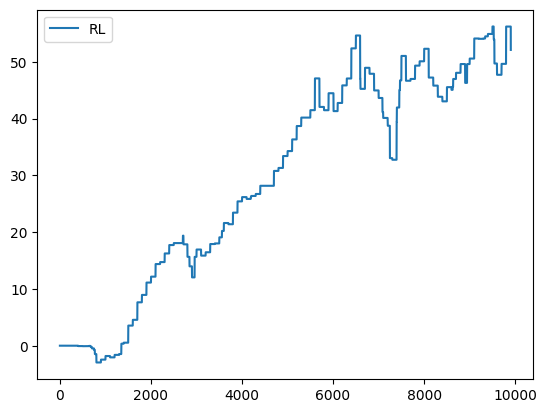

In [76]:
pnl_rl = pnl_history
# plt.plot(pnl_neg, label='pessimistic')
# plt.plot(pnl_opt, label='optimistic')
plt.plot(pnl_rl, label='RL')
plt.legend()
plt.show()

In [77]:
with open(f'pnls/{dim_hidden}_{features.shape[1]}_{is_base}.npy', 'wb') as f:
    np.save(f, np.array(pnl_history))

123
123
54.6
123

In [82]:
with open('costs/16_11_True.npy', 'rb') as f:
    cost1 = np.load(f)

with open('costs/32_11_False.npy', 'rb') as f:
    cost2 = np.load(f)
 
with open('costs/64_11_True.npy', 'rb') as f:
    cost3 = np.load(f)

In [79]:
with open('pnls/16_11_False.npy', 'rb') as f:
    pnl1 = np.load(f)

with open('pnls/32_11_True.npy', 'rb') as f:
    pnl2 = np.load(f)
 
with open('pnls/64_11_True.npy', 'rb') as f:
    pnl3 = np.load(f)

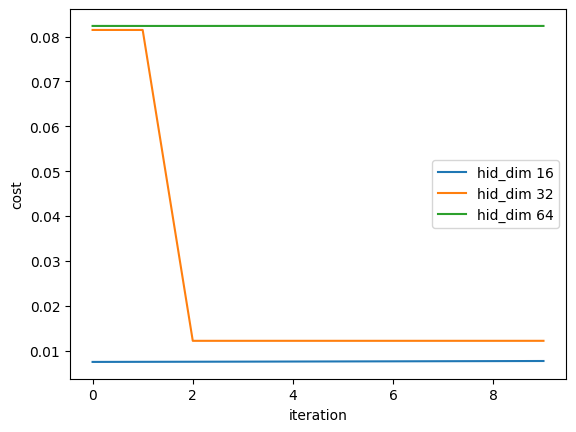

In [83]:
plt.plot(cost1, label='hid_dim 16')
plt.plot(cost2, label='hid_dim 32')
plt.plot(cost3, label='hid_dim 64')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('cost')
plt.show()

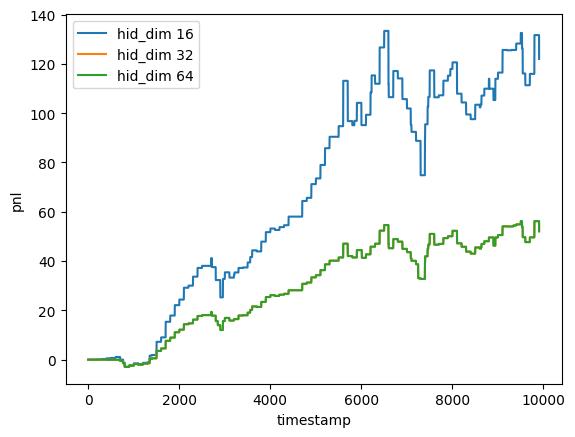

In [84]:
plt.plot(pnl1, label='hid_dim 16')
plt.plot(pnl2, label='hid_dim 32')
plt.plot(pnl3, label='hid_dim 64')
plt.legend()
plt.xlabel('timestamp')
plt.ylabel('pnl')
plt.show()